In [22]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy

In [23]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")
test_ground_truth=pd.read_csv("../dataset/sdoh_test_labels.csv")

In [24]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [25]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [27]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [28]:
merged_df.shape

(4343, 186)

In [29]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [30]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [31]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [32]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

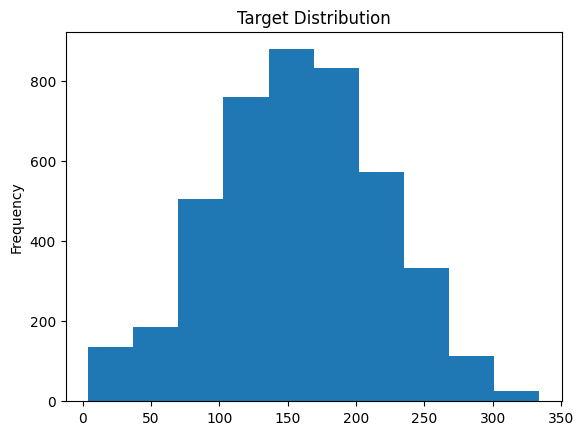

In [33]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [34]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

In [35]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

/tmp/ipykernel_3030275/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_3030275/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_3030275/2658724754.py:13: FutureWarning: Downcasting behavior i

In [36]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [37]:
merged_df.shape

(4343, 196)

In [39]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
unique_uids = merged_df['uid'].unique()  # Extract unique uids

for train_ids, val_ids in tqdm(KFold(n_splits=5, shuffle=True, random_state=42).split(unique_uids)):
    # Split the data
    train_uids, val_uids = unique_uids[train_ids], unique_uids[val_ids]
    keep_train = merged_df['uid'].isin(train_uids)
    keep_val = merged_df['uid'].isin(val_uids)
    
    train_X, val_X = merged_df[keep_train], merged_df[keep_val]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    train_y, val_y = y[keep_train], y[keep_val]

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')

    # Define parameters
    params = {
        'objective': 'regression',  # default for regression
        'metric': 'rmse',
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'random_seed': 42
    }

    # Train the model with early stopping
    model1 = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/3, 1/3, 1/3]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]/tmp/ipykernel_3030275/1304367129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3030275/1304367129.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.322657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 195
[LightGBM] [Info] Start training from score 155.317235
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[422]	valid_0's rmse: 41.2762
0:	learn: 60.4430980	test: 61.5913317	best: 61.5913317 (0)	total: 71.5ms	remaining: 11m 55s
100:	learn: 44.8009187	test: 47.7005129	best: 47.7005129 (100)	total: 3s	remaining: 4m 54s
200:	learn: 38.3792230	test: 43.6847336	best: 43.6847336 (200)	total: 5.78s	remaining: 4m 41s
300:	learn: 34.8962145	test: 42.3996257	best: 42.3996257 (300)	total: 8.58s	remaining: 4m 36s
400:	learn: 32.5886698	test: 41.8341143	best: 41.8341143 (400)	total: 11.9s	remaining: 4m 45s


1it [01:58, 118.66s/it]/tmp/ipykernel_3030275/1304367129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3030275/1304367129.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1892
[LightGBM] [Info] Number of data points in the train set: 3481, number of used features: 195
[LightGBM] [Info] Start training from score 157.507613
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[574]	valid_0's rmse: 41.0112
0:	learn: 60.4830356	test: 61.3242055	best: 61.3242055 (0)	total: 18.3ms	remaining: 3m 3s
100:	learn: 45.1529612	test: 47.7519250	best: 47.7519250 (100)	total: 2.55s	remaining: 4m 9s
200:	learn: 38.7357201	test: 43.6488295	best: 43.6488295 (200)	total: 5.37s	remaining: 4m 21s
300:	learn: 35.1834772	test: 42.1307624	best: 42.1307624 (300)	total: 8.13s	remaining: 4m 21s
400:	learn: 32.8211191	test: 41.5193357	best: 41.5193357 (400)	total: 10.9s	remaining: 4m 20s


2it [04:21, 132.90s/it]/tmp/ipykernel_3030275/1304367129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3030275/1304367129.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 3477, number of used features: 195
[LightGBM] [Info] Start training from score 158.134311
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[688]	valid_0's rmse: 40.4552
0:	learn: 61.4150770	test: 57.4708638	best: 57.4708638 (0)	total: 20.6ms	remaining: 3m 26s
100:	learn: 45.2200278	test: 46.1812095	best: 46.1812095 (100)	total: 2.57s	remaining: 4m 11s
200:	learn: 38.5792336	test: 43.1157092	best: 43.1157092 (200)	total: 5.45s	remaining: 4m 25s
300:	learn: 35.1433589	test: 41.9300737	best: 41.9300737 (300)	total: 8.15s	remaining: 4m 22s
400:	learn: 32.8182959	test: 41.4091836	best: 41.4091836 (400)	total: 11s	remaining: 4m 22s


3it [06:50, 140.19s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 195


/tmp/ipykernel_3030275/1304367129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3030275/1304367129.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score 156.698043
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[577]	valid_0's rmse: 41.0754
0:	learn: 60.7661126	test: 60.1572039	best: 60.1572039 (0)	total: 21.7ms	remaining: 3m 36s
100:	learn: 45.1214796	test: 46.9076758	best: 46.9076758 (100)	total: 2.66s	remaining: 4m 20s
200:	learn: 39.0457187	test: 43.0512715	best: 43.0512715 (200)	total: 5.26s	remaining: 4m 16s
300:	learn: 35.7130050	test: 41.5923459	best: 41.5923459 (300)	total: 8.03s	remaining: 4m 18s
400:	learn: 33.4141675	test: 40.9828461	best: 40.9828461 (400)	total: 11.2s	remaining: 4m 27s
500:	learn: 31.7222877	test: 40.6145896	best: 40.6138850 (499)	total: 14.1s	remaining: 4m 27s
600:	learn: 30.3912968	test: 40.4372642	best: 40.4372642 (600)	total: 17.2s	remaining: 4m 28s
700:	learn: 29.0922267	test: 40.3293618	best: 40.3288986 (698)	total: 20.2s	remaining: 4m 28s
800:	learn: 28.1308875	test: 40.2668842	best: 40.2645848 (793)	total:

4it [08:38, 127.55s/it]/tmp/ipykernel_3030275/1304367129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_3030275/1304367129.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 3482, number of used features: 195
[LightGBM] [Info] Start training from score 157.416140
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[853]	valid_0's rmse: 41.2058
0:	learn: 60.0683039	test: 62.9451960	best: 62.9451960 (0)	total: 24.7ms	remaining: 4m 6s
100:	learn: 45.1472597	test: 48.4898203	best: 48.4898203 (100)	total: 2.51s	remaining: 4m 5s
200:	learn: 38.9242131	test: 43.9389286	best: 43.9389286 (200)	total: 5.25s	remaining: 4m 15s
300:	learn: 35.4808212	test: 42.2115155	best: 42.2115155 (300)	total: 8.21s	remaining: 4m 24s
400:	learn: 33.1908536	test: 41.4492290	best: 41.4492290 (400)	total: 11s	remaining: 4m 24s
50

5it [10:30, 126.13s/it]

Average MSE across folds: 40.28252147664635
Optimized weights per fold: [array([0.22462682, 0.4423182 , 0.33305498]), array([0.27806282, 0.72193718, 0.        ]), array([0.35959974, 0.30649829, 0.33390197]), array([7.62019383e-18, 6.91585911e-01, 3.08414089e-01]), array([0.0539612 , 0.79093617, 0.15510263])]


In [40]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 40.28252147664635


In [41]:
np.mean(optimized_weights_list, axis=0)

array([0.18325011, 0.59065515, 0.22609473])

In [ ]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

merged_df.drop(columns=['uid'], inplace=True)
merged_test.drop(columns=['uid'], inplace=True)

# Train models on the entire training dataset
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

params = {
    'objective': 'regression',  # default for regression
    'metric': 'rmse',
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_seed': 42
}
final_model1 = lgb.train(
    params,
    train_data
)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error)
final_model3.fit(merged_df, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('../dataset/LGBM_and_CatBoost_and_XGBoost_engineering_v2.csv', index=False)

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.392868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2030
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 195
[LightGBM] [Info] Start training from score 157.016809
0:	learn: 60.6706359	total: 6.56ms	remaining: 1m 5s
100:	learn: 45.1469297	total: 2.63s	remaining: 4m 17s
200:	learn: 39.1364111	total: 5.49s	remaining: 4m 27s
300:	learn: 35.8111622	total: 8.58s	remaining: 4m 36s
400:	learn: 33.7047091	total: 11.5s	remaining: 4m 35s
500:	learn: 32.1122361	total: 14.5s	remaining: 4m 34s
600:	learn: 30.7861504	total: 17.9s	remaining: 4m 40s
700:	learn: 29.6481136	total: 21.1s	remaining: 4m 40s
800:	learn: 28.6747853	total: 24.6s	remaining: 4m 42s
900:	learn: 27.7920805	total: 27.7s	remaining: 4m 40s
1000:	learn: 26.9744507	total: 31.1s	remaining: 4m 39s

In [43]:
# mean squared error on test set
root_mean_squared_error(test_ground_truth['composite_score'], ss['composite_score'])

39.368016510638434